In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# plt.rcparams222['image.cmap'] = 'gray'

show_all = True

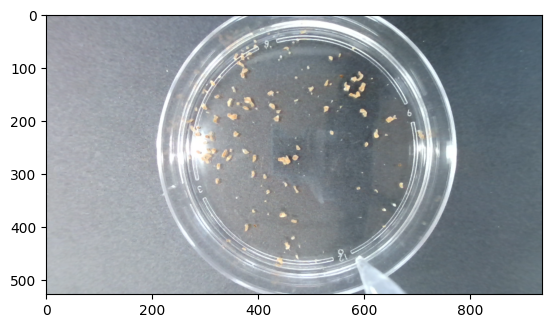

In [19]:
image = cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
inverted_gray_image = 255 - gray_image
if show_all:
    plt.imshow(image)

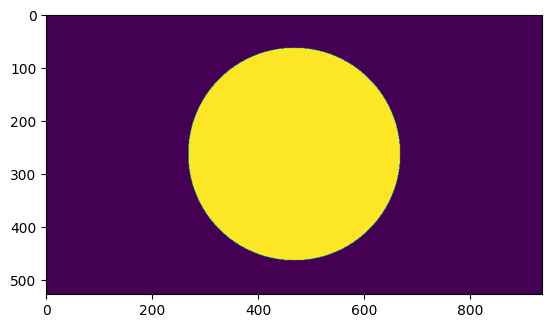

In [20]:
mask = np.zeros(image.shape[0:2], dtype='uint8')

center_coordinates = (int(mask.shape[1]/2), int(mask.shape[0]/2))
radius = 200
color = 255
thickness = -1

mask = cv2.circle(mask, center_coordinates, radius, color, thickness)
            
if show_all:
    plt.imshow(mask)

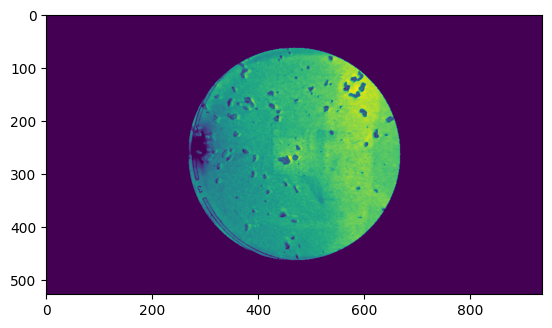

In [21]:
zoi = cv2.bitwise_and(inverted_gray_image, inverted_gray_image, mask=mask)
if show_all:
    plt.imshow(zoi)

In [22]:
YELLOW = (255, 255, 0)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)


def d_circle(img, keypoints, radius, color):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1

    for i in range(len(keypoints)):
            out = cv2.circle(img, (int(keypoints[i].pt[0]),int(keypoints[i].pt[1])), radius, color, thickness)      
    
    return img
    
    
def d_number(img, keypoints, color):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1

    for i in range(len(keypoints)):
            size, _ = cv2.getTextSize(str(i+1), font, fontScale, thickness)
            img = cv2.putText(img, str(i+1), (int(keypoints[i].pt[0]-size[0]/2),int(keypoints[i].pt[1]-5)), font, 
                    fontScale, color, thickness, cv2.LINE_AA)
    
    return img

def d_angles(img, keypoint, angles, color):
        
    thickness = 1  
    length = 30
      
    for i in range(len(angles)):
        end_point = (int(keypoint.pt[0]+length*math.cos(angles[i])), int(keypoint.pt[1]+length*math.sin(angles[i])))
        img = cv2.line(img, (int(keypoint.pt[0]),int(keypoint.pt[1])), end_point, color, thickness)   
    
    return img  

In [23]:

def create_sample_detector():

    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 10
    params.maxThreshold = 200


    # Filter by Area.
    params.filterByArea = True
    params.minArea = 50
    params.maxArea = 70

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.8

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.5

    # Create a detector with the parameters
    # OLD: detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    
    return detector

In [24]:
def create_agreagate_detector():
    
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 10
    params.maxThreshold = 240


    # Filter by Area.
    params.filterByArea = True
    params.minArea = 200
    params.maxArea = 500

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.8

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.5
    
    # Create a detector with the parameters
    # OLD: detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    
    return detector

In [25]:

def create_intruder_detector():
    
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 10
    params.maxThreshold = 240


    # Filter by Area.
    params.filterByArea = True
    params.minArea = 30
    params.maxArea = 500

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.8

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.5
    
    # Create a detector with the parameters
    # OLD: detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    
    return detector

In [26]:
def distance(keypoint1, keypoint2):
    return math.sqrt((keypoint1.pt[0]-keypoint2.pt[0])**2 + (keypoint1.pt[1]-keypoint2.pt[1])**2)

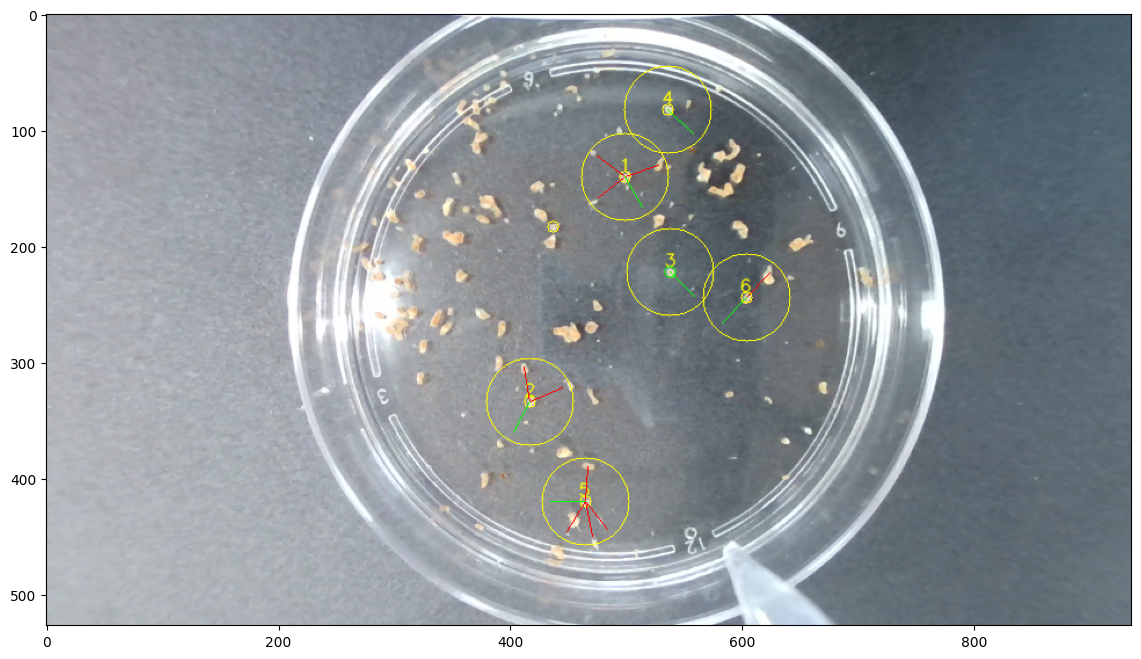

In [27]:
out = image.copy()

close_radius = 38
too_close_radius = 15

sample_detector = create_sample_detector()
intruder_detector = create_intruder_detector()

# Detect blobs.
keypoints = sample_detector.detect(zoi)
keypoints_intruders = intruder_detector.detect(zoi)

out = d_circle(out, keypoints, 5, YELLOW)

smallest_distances = []
close_angles = []
i = 0

while i < len(keypoints):
    
    elements = []
    angles = []
    nb_too_close = 0
    smallest_dist = close_radius
    
    for j in range(len(keypoints_intruders)):
        
        dist = distance(keypoints[i], keypoints_intruders[j])
        
        if dist < too_close_radius:
            nb_too_close += 1
            
        elif dist < close_radius:
            if dist < smallest_dist:
                smallest_dist = dist
                
            angles.append(math.atan2((keypoints_intruders[j].pt[1]-keypoints[i].pt[1]), (keypoints_intruders[j].pt[0]-keypoints[i].pt[0])))
            
    # If elements too close remove keypoint, else keep the close elements on the table 
    if nb_too_close <= 1:
        # angles = [x for x in angles if x > -math.pi/2.0]
        # angles.append(math.pi)
        # angles.append(-math.pi/2.0)
        angles.sort()
        close_angles.append(angles)
        smallest_distances.append(smallest_dist)
        i += 1
    else:
        keypoints = tuple(item for item in keypoints if item != keypoints[i])
  
optimal = False        
out = d_number(out, keypoints, YELLOW)
out = d_circle(out, keypoints, close_radius, YELLOW)  
for i in range(len(keypoints)):
    out = d_angles(out, keypoints[i], close_angles[i], RED)  
               
if optimal:        

    id_target = smallest_distances.index(max(smallest_distances))
    angles = close_angles[id_target]
    angles_diff = []
    if len(angles) > 0:
        for i in range(len(angles)-1):
            angles_diff.append(angles[i+1]-angles[i])
        angles_diff.append(2*math.pi+angles[0]-angles[-1])

        id_angle = angles_diff.index(max(angles_diff))
        # if id_angle == 0:
        #     optimal_angle = angles[0]
        # elif id_angle == len(angles)-1:
        #     optimal_angle = angles[-1]
        # else:
        optimal_angle = angles[id_angle]+angles_diff[id_angle]/2.0
    else:
        optimal_angle = math.pi/4.0
        
    
    optimal_angle = (optimal_angle + 3*math.pi) %  (2*math.pi) - math.pi
        
    if optimal_angle < -3.*math.pi/8.:
        if optimal_angle < -3.*math.pi/4.:
            optimal_angle = math.pi
        else:
            optimal_angle = -3.*math.pi/8.

    out = d_angles(out, keypoints[id_target], [optimal_angle], GREEN)   
    out = d_circle(out, [keypoints[id_target]], 5, GREEN)

else:
    for i in range(len(keypoints)):  
        id_target = i

        angles = close_angles[id_target]
        angles_diff = []
        if len(angles) > 0:
            for i in range(len(angles)-1):
                angles_diff.append(angles[i+1]-angles[i])
            angles_diff.append(2*math.pi+angles[0]-angles[-1])

            id_angle = angles_diff.index(max(angles_diff))
            # if id_angle == 0:
            #     optimal_angle = angles[0]
            # elif id_angle == len(angles)-1:
            #     optimal_angle = angles[-1]
            # else:
            optimal_angle = angles[id_angle]+angles_diff[id_angle]/2.0
        else:
            optimal_angle = math.pi/4.0
            
        optimal_angle = (optimal_angle + 3*math.pi) %  (2*math.pi) - math.pi
        
        if optimal_angle < -3.*math.pi/8.:
            if optimal_angle < -3.*math.pi/4.:
                optimal_angle = math.pi
            else:
                optimal_angle = -3.*math.pi/8.
            
        out = d_angles(out, keypoints[id_target], [optimal_angle], GREEN)   
    
    id_target = smallest_distances.index(max(smallest_distances))    
    out = d_circle(out, [keypoints[id_target]], 5, GREEN)  
          
plt.figure(figsize=(14,10))
plt.imshow(out)

In [28]:
smallest_distances.index(max(smallest_distances))

2

In [29]:
optimal_angle = 5
optimal_angle = (optimal_angle + 3*math.pi) %  (2*math.pi) - math.pi
print(optimal_angle)

-1.2831853071795862


In [30]:

out = image.copy()

sample_detector = create_sample_detector()
intruder_detector = create_intruder_detector()


# Detect blobs.
keypoints = sample_detector.detect(zoi)
keypoints_intruders = intruder_detector.detect(zoi)
# keypoints_agregates = agregate_detector.detect(zoi)


# i = 0
# while i < len(keypoints_intruders):
#         for j in range(len(keypoints)):
#                 if (keypoints_intruders[i].pt[0]-keypoints[j].pt[0])**2+ (keypoints_intruders[i].pt[1]-keypoints[j].pt[1])**2 < 5**2:
#                         keypoints_intruders = tuple(item for item in keypoints_intruders if item != keypoints_intruders[i])
#         i += 1
                

# Draw intruders
radius = 5
color = (0, 0, 255)
thickness = 2

for i in range(len(keypoints_intruders)):
        out = cv2.circle(out, (int(keypoints_intruders[i].pt[0]),int(keypoints_intruders[i].pt[1])), radius, color, thickness)

# # Draw agregates
# radius = 5
# color = (255, 0, 0)
# thickness = 2

# for i in range(len(keypoints_agregates)):
#         out = cv2.circle(out, (int(keypoints_agregates[i].pt[0]),int(keypoints_agregates[i].pt[1])), radius, color, thickness)

# Draw samples
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
color = (0, 255, 0)
thickness = 1

radius = 5
color_c = (255, 0, 0)
thickness_c = 2

for i in range(len(keypoints)):
        size, _ = cv2.getTextSize(str(i+1), font, fontScale, thickness)
        out = cv2.putText(out, str(i+1), (int(keypoints[i].pt[0]-size[0]/2),int(keypoints[i].pt[1]-5)), font, 
                   fontScale, color, thickness, cv2.LINE_AA)
        # out = cv2.circle(out, (int(keypoints[i].pt[0]),int(keypoints[i].pt[1])), radius, color_c, thickness_c)

        
# Show blobs



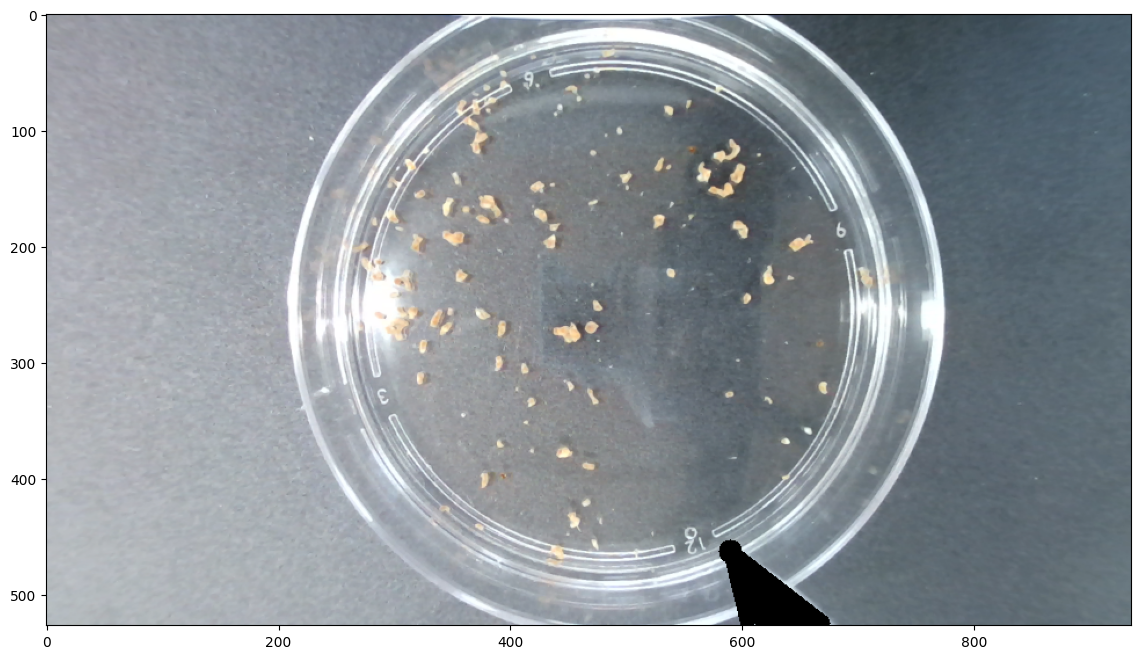

In [48]:
dev = image.copy()
color = (0,0,0)
thickness = -1
radius = 10
pos = [590, 463]
p1 = [605, 525]
p2 = [670, 525]

# cv2.line(dev, p1, p2, (255, 0, 0), 3)
cv2.line(dev, pos, p1, color, 12)
cv2.line(dev, pos, p2, color, 12)
cv2.line(dev, pos, ((p1[0]+p2[0])//2,(p1[1]+p2[1])//2), color, 12)
cv2.line(dev, pos, ((2*p1[0]+p2[0])//3,(2*p1[1]+p2[1])//3), color, 12)
cv2.line(dev, pos, ((p1[0]+2*p2[0])//3,(p1[1]+2*p2[1])//3), color, 12)
cv2.line(dev, pos, ((4*p1[0]+p2[0])//5,(4*p1[1]+p2[1])//5), color, 12)
cv2.line(dev, pos, ((p1[0]+4*p2[0])//5,(p1[1]+4*p2[1])//5), color, 12)

dev = cv2.circle(dev, pos, radius, color, thickness)  
plt.figure(figsize=(14,10))
plt.imshow(dev)

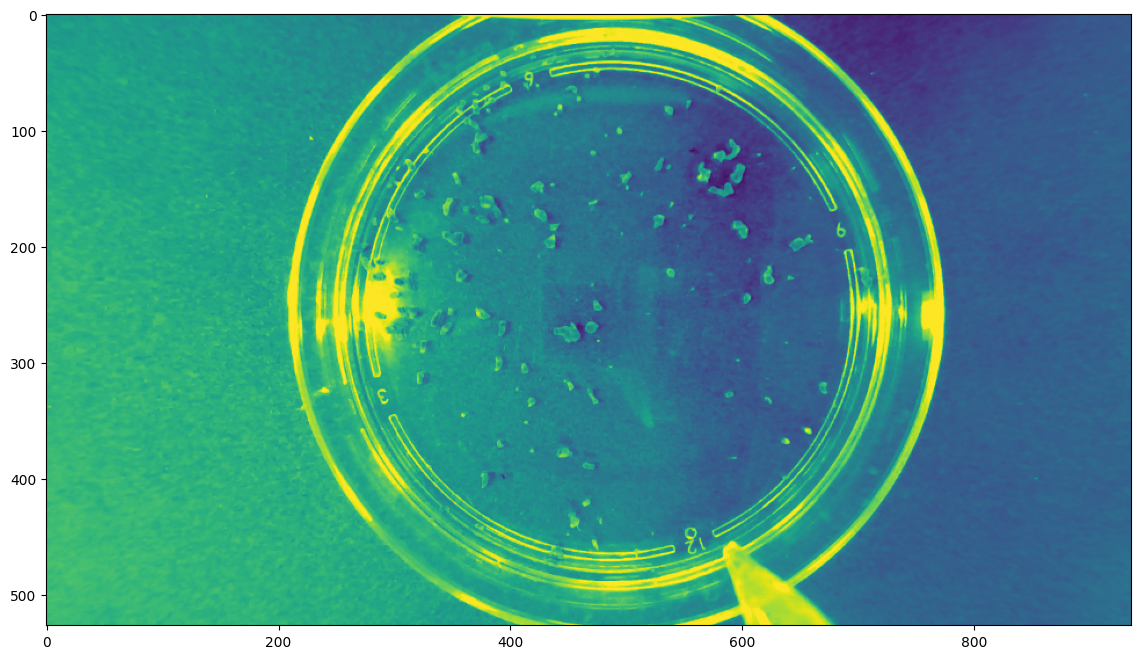

In [52]:
channel = image.copy()
plt.figure(figsize=(14,10))
plt.imshow(channel[:,:,2])

# Results
Very good results, very few false positives and a good detection, can discriminate by size and non convex shapes 

In [14]:
percent = 50

max = math.cos(2648*math.pi/4096)
min = math.cos(2158*math.pi/4096)
        
pos = math.acos(min + percent/100.0*(max-min))/math.pi*4096
percent = 100*((math.cos(math.pi*pos/4096)-min)/(max-min))
print(pos)
print(percent)

2396.5958990740296
50.000000000000014
